In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.models import Config3D, StarDist3D, StarDistData3D

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

Using TensorFlow backend.


1.13.2


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9368663883398751388
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1454556193520674939
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7732779418
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17749555023757565798
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12820449940787158016
physical_device_desc: "device: XLA_GPU device"
]


# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [3]:
X = sorted(glob('data/train/images/*.tif'))
Y = sorted(glob('data/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]

Normalize images and fill small label holes.

In [5]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 27/27 [00:00<00:00, 37.53it/s]


Split into train and validation datasets.

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  27
- training:        23
- validation:       4


Training data consists of pairs of input image and label instances.

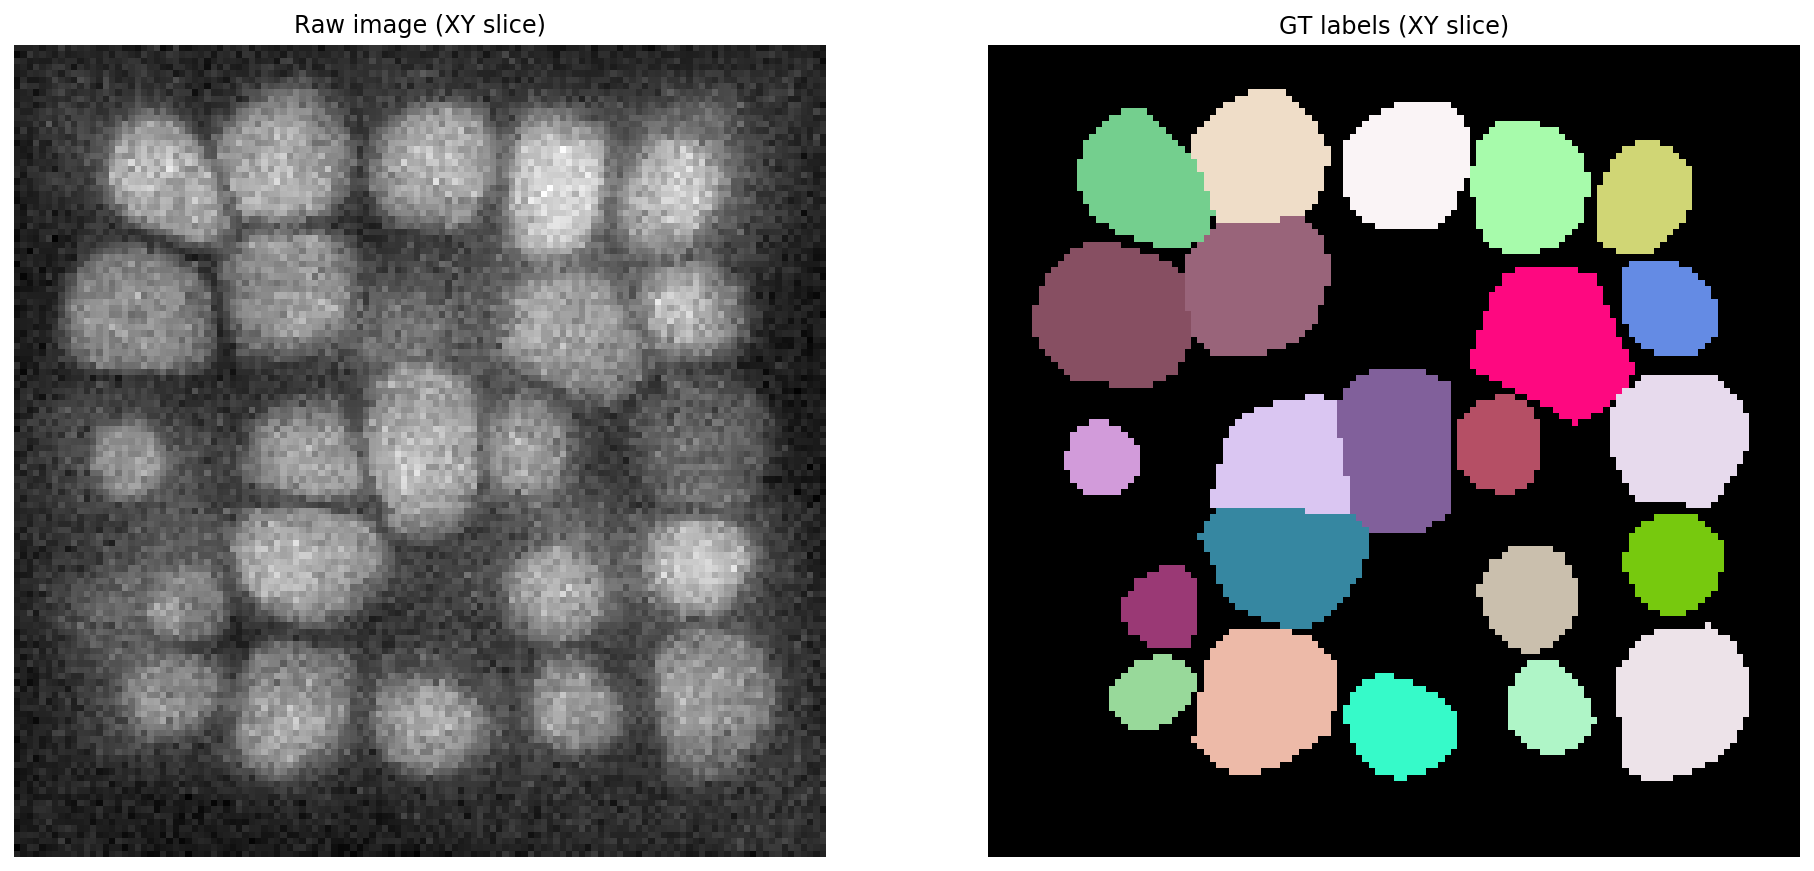

In [7]:
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
z = img.shape[0] // 2
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [8]:
# print(Config3D.__doc__)

In [9]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (2.0, 1.0, 1.0)


In [10]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (48,96,96),
    train_batch_size = 2,
)
print(conf)
vars(conf)

Config3D(anisotropy=(2.0, 1.0, 1.0), axes='ZYXC', backbone='resnet', grid=(1, 2, 2), n_channel_in=1, n_channel_out=97, n_dim=3, n_rays=96, net_conv_after_resnet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), norm_by_mask=True, rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (2.0, 1.0, 1.0)}}, resnet_activation='relu', resnet_batch_norm=False, resnet_kernel_init='he_normal', resnet_kernel_size=(3, 3, 3), resnet_n_blocks=4, resnet_n_conv_per_block=3, resnet_n_filter_base=32, train_background_reg=0.0001, train_batch_size=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_one_cycle_lr_max=None, train_patch_size=(48, 96, 96), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_steps_per_ep

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (1, 2, 2),
 'anisotropy': (2.0, 1.0, 1.0),
 'backbone': 'resnet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96, 'anisotropy': (2.0, 1.0, 1.0)}},
 'resnet_n_blocks': 4,
 'resnet_kernel_size': (3, 3, 3),
 'resnet_kernel_init': 'he_normal',
 'resnet_n_filter_base': 32,
 'resnet_n_conv_per_block': 3,
 'resnet_activation': 'relu',
 'resnet_batch_norm': False,
 'net_conv_after_resnet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (48, 96, 96),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 2,
 'train_n_val

In [11]:
from csbdeep.utils.tf import limit_gpu_memory
# adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
limit_gpu_memory(0.8, allow_growth=True)

**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [12]:
model = StarDist3D(conf, name='stardist3D', basedir='models_test0')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


/home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /home/lis-paul/stardist/examples/3D/models_test0/stardist3D
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [12]:
# median_size = calculate_extents(Y, np.median)
# fov = np.array(model._axes_tile_overlap('ZYX'))
# if any(median_size > fov):
#     print("WARNING: median object size larger than field of view of the neural network.")

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv3d_1/convolution}}]]

# Training

You can define a function/callable that applies augmentation to each batch of the data generator.

In [13]:
augmenter = None

# def augmenter(x, y):
#     """Augmentation of a single input/label image pair.
#     x is an input image
#     y is the corresponding ground-truth label image
#     """
#     # modify a copy of x and/or y...
#     return x, y

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [14]:
quick_demo = True

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=5)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D(None, name='3D_demo', basedir='../../models/examples')
    model.basedir = None # to prevent files of the demo model to be overwritten (not needed for your model)
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

NOTE: This is only for a quick demonstration!
      Please set the variable 'quick_demo = False' for proper (long) training.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Epoch 1/2


InternalError: Blas SGEMM launch failed : m=221184, n=1, k=128
	 [[{{node prob/convolution}}]]
	 [[{{node metrics/kld/Mean_1}}]]

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [15]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [01:02<00:23,  4.67s/it, 0.710 -> 0.988]


Using optimized values: prob_thresh=0.707933, nms_thresh=0.3.
